In [1]:
using MatterPower
using Roots
using Plots
using LaTeXStrings
using LinearAlgebra
using Statistics
using QuadGK, Plots

gr()  # Set GR as the backend

Plots.GRBackend()

In [2]:
module DarkEnergyModule
    using DifferentialEquations
    using PyCall
    using Plots
    using LaTeXStrings
    using QuadGK

    # Import the Python camb module and dark energy submodule
    cb = pyimport("camb")
    DarkEnergyPPF = pyimport("camb.dark_energy").DarkEnergyPPF

    # Define a struct to encapsulate dark energy parameters
    struct DarkEnergyModel
        Ωm::Float64  # Total matter density parameter
        ΩΛ::Float64  # Dark energy density parameter
        w0::Float64  # EoS parameter
        wa::Float64  # Evolution of EoS
        h::Float64   # Hubble constant in units of 100 km/s/Mpc
        pars1::PyObject  # CAMB parameters
        results1::PyObject  # CAMB results
    end

    # Constructor with CAMB setup
    function DarkEnergyModel(Ωm::Float64, ΩΛ::Float64, w0::Float64, wa::Float64, h::Float64)
        # Calculate baryon and cold dark matter densities
        ombh2 = 0.045 * h^2  # Assuming baryon fraction is 0.045
        omch2 = (Ωm - 0.045) * h^2  # Cold dark matter density
        
        # Initialize CAMB parameters
        pars1 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        pars2 = cb.set_params(H0=h * 100, ombh2=ombh2, omch2=omch2, ns=0.965)
        
        # Configure matter power and non-linear settings
        pars1["set_matter_power"](redshifts=[0.0], kmax=10.0)
        pars1["NonLinear"] = cb.model["NonLinear_none"] #for linear choose _none else _both
        results1 = cb.get_results(pars1)
        
        return DarkEnergyModel(Ωm, ΩΛ, w0, wa, h, pars1, results1)
    end

    # Dynamical dark energy equation of state
    function DE_EoS(self::DarkEnergyModel, redshift::Float64)
        w0, wa = self.w0, self.wa
        return (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
    end


    # Define methods for the DarkEnergyModel struct
    function growth(self::DarkEnergyModel, a1::Real=1e-2)
        Ωm, ΩΛ, w0, wa = self.Ωm, self.ΩΛ, self.w0, self.wa
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a1 - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E1 = √(Ωm / a1^3 + Ωk / a1^2 + ΩΛ * DEoS)
        u0 = [a1; -a1^2 * E1]
        tspan = (a1, 1.0)
        prob = ODEProblem((du, u, p, a) -> growth_set!(du, u, p, a, w0, wa), u0, tspan, [Ωm, ΩΛ])
        return solve(prob, Tsit5())
    end

    function growth_set!(du, u, p, a, w0, wa)
        δ, θ = u
        Ωm, ΩΛ = p
        Ωk = 1 - Ωm - ΩΛ
        redshift = 1 / a - 1
        DEoS = (1 + redshift)^(3 * (1 + w0 + wa)) * exp(-3 * wa * (redshift / (1 + redshift)))
        E = √(Ωm / a^3 + Ωk / a^2 + ΩΛ * DEoS)  # E(a) = H(a)/H0
        q2ϕ = -(3 / 2) * Ωm * δ / a  # Poisson equation
        du[1] = -θ / a^2 / E  # Continuity equation
        du[2] = -θ / a + q2ϕ / a^2 / E  # Euler equation
    end

    # Redshift-dependent growth factor
    function dz(self::DarkEnergyModel, redshift::Float64)
        sol = growth(self)
        a = 1 / (1 + redshift)
        return sol(a)[1]
    end

# Growth rate calculation
    function growth_rate(self::DarkEnergyModel, redshift::Float64)
        step = 0.01  # Step size for numerical stability
        dzda = (dz(self, redshift + step) - dz(self, redshift - step)) / (2 * step)
        g = - (1 + redshift) * dzda / dz(self, redshift)
        return g
    end

    # Normalized Hubble rate
    function normalized_hubble_rate(self::DarkEnergyModel, redshift::Float64)
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        Ωk = 1 - Ωm - ΩΛ
        DEoS = DE_EoS(self, redshift)
        return √(Ωm / (1 + redshift)^(-3) + Ωk / (1 + redshift)^(-2) + ΩΛ * DEoS)
    end

    function comoving_distance(self::DarkEnergyModel, redshift::Union{Float64, AbstractArray{Float64}})
        if isa(redshift, Float64)
            # Single redshift
            integrand(z) = 1 / normalized_hubble_rate(self, z)
            result, error = quadgk(integrand, 0, redshift)
            return result * 2997.98 / self.h
        else
            # Array of redshifts: Apply to each redshift
            return [comoving_distance(self, z) for z in redshift]
        end
    end

    # Angular Diameter Comoving distance in MPc
    function comoving_angular_distance(self::DarkEnergyModel, redshift::Float64)
        return comoving_distance(self, redshift)/(1+redshift)
    end

    # Linear power spectrum from CAMB
    function get_power_spectrum(self::DarkEnergyModel, kh::Vector{Float64}, redshift::Float64)
        # Extract matter power spectrum from CAMB
        _, _, pk_lcdm = self.results1["get_matter_power_spectrum"](minkh=minimum(kh), maxkh=maximum(kh), npoints=length(kh))
        # Convert Python arrays to Julia arrays
        pk_lcdm = collect(pk_lcdm)
         # Normalize the power spectrum using dz
        normalized_pk = pk_lcdm * (dz(self, Float64(redshift))^2 / dz(self, 0.0)^2)
    
        return normalized_pk
    end

    function t_nowiggle(self::DarkEnergyModel, kh::Vector{Float64}) 
    # Cosmological parameters
      # Apply the scaling factor to kh
        #kh = kh .* self.h  # Element-wise multiplication by 0.67
        h0 = self.h
        Ωb = 0.049
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        ωm, fb = Ωm * h0^2, Ωb / Ωm
        α = 1 - 0.328fb * log(431ωm) + 0.38 * fb^2 * log(22.3ωm)
        s = 44.5 * log(9.83 / ωm) / √(1 + 10 * (fb * ωm)^(3 / 4))
        Γ = ωm * (α .+ (1 .- α) ./ (1 .+ (0.43 .* kh .* s).^4))  # Element-wise operations
        q = kh .* (2.725 / 2.7)^2 ./ Γ
        return log.(2 * exp(1) .+ 1.8 .* q) ./ 
           (log.(2 * exp(1) .+ 1.8 .* q) .+ (14.2 .+ 731 ./ (1 .+ 62.5 .* q)) .* q.^2)
    end


    function MatterPS(self::DarkEnergyModel, kh::Vector{Float64}, redshift::Float64)
    # Cosmological parameters
        #kh = kh .* self.h  # Element-wise multiplication by 0.67
        h0 = self.h
        As, ns, kpivot = 2.097e-9, 0.9652, 0.05
        Ωb = 0.049
        h0 = self.h
        Ωm, ΩΛ = self.Ωm, self.ΩΛ
        ωm, fb = Ωm * h0^2, Ωb / Ωm

    # Element-wise operations on kh
        scaled_kh = kh .* h0 ./ kpivot  # Element-wise scaling of kh
        power_spectrum = dz(self, redshift)^2/dz(self, 0.0)^2 * As .* scaled_kh.^(ns - 1) .* (2 .* kh.^2 * 2998^2 / 5 / Ωm).^2
        transfer_function = t_nowiggle(self, kh).^2
        Ps = power_spectrum .* transfer_function .* 2 * π^2 ./ kh.^3  # Final element-wise multiplication
    
        return Ps/1.18 #1.18 is divided just to fit with CAMB
    end

    export dz, comoving_distance, comoving_angular_distance, DarkEnergyModel, normalized_hubble_rate, get_power_spectrum, t_nowiggle, MatterPS
end


using .DarkEnergyModule
using Revise


darkenergy = DarkEnergyModule.DarkEnergyModel(0.31, 0.69, -1.0, -0.0, 0.67)

# Function to apply Simpson's rule on an array
function simps(y, x)
    n = length(x)
    if n < 3 || n % 2 == 0
        error("Simpson's rule requires an odd number of points.")
    end

    dx = (x[end] - x[1]) / (n - 1)
    result = y[1] + y[end] + 4 * sum(y[2:2:end-1]) + 2 * sum(y[3:2:end-2])
    return result * dx / 3
end



simps (generic function with 1 method)

In [3]:
# Performing \mu integration
function delta_vel_kernel(k::Float64, kprime::Float64, mu::Float64, z::Float64)
    # Compute the numerator and denominator for the kernel
    numerator = k * (k - 2 * kprime * mu) * (1 - mu^2)
    denominator = kprime^2 * (k^2 + kprime^2 - 2 * k * kprime * mu)
    
    # Compute the kernel factor
    factor = numerator / denominator

    # Get the power spectrum for kprime
    pk_prime = DarkEnergyModule.get_power_spectrum(darkenergy, [kprime * 0.999, kprime * 1.001], 0.0) 
    pk_prime_mean = mean(pk_prime)  # Take the mean of pk_prime
    
    # Get the power spectrum for k - kprime
    k_minus_kprime = norm(k - kprime)
    #k_minus_kprime = sqrt(k^2 + kprime^2 - (2 * k * kprime * mu))
    
    pk = DarkEnergyModule.get_power_spectrum(darkenergy, [k_minus_kprime * 0.999, k_minus_kprime * 1.001], 0.0)
    pk_mean = mean(pk)  # Take the mean of pk
    
    # Compute the redshift-dependent term
    REDSHIFT_TERM = DarkEnergyModule.normalized_hubble_rate(darkenergy, z)^2 * darkenergy.h^2 * 100^2 * DarkEnergyModule.growth_rate(darkenergy, z)^2 / (1 + z)^2
     
    
    # Compute the integrand for a given mu
    integrand = pk_mean * pk_prime_mean * factor * REDSHIFT_TERM * (4 * pi * kprime^2) * k^3 / (16 * pi^5)
    
    return integrand
end

function integrate_over_mu(k::Float64, kprime::Float64, z::Float64)
    # Integrate delta_vel_kernel over mu from -1 to 1
    result, _ = quadgk(mu -> delta_vel_kernel(k, kprime, mu, z), -1.0, 1.0, rtol=1e-6)
    return result
end

# Now perform the integration over kprime using the result from integrate_over_mu
k_value = 0.1  # Set a fixed value for k, can be any number you want
kprime_min = 0.001
kprime_max = 0.1
z = 0.0

#integration_result, _ = quadgk(kprime -> integrate_over_mu(k_value, kprime, z), kprime_min, kprime_max, rtol=1e-6)

#println("Integration result: ", integration_result)
function delta_vel_kernel_no_bao(k::Float64, kprime::Float64, mu::Float64, z::Float64)
    # Compute the numerator and denominator for the kernel
    numerator = k .* (k .- 2 .* kprime .* mu) .* (1 .- mu.^2)
    denominator = kprime.^2 .* (k.^2 .+ kprime.^2 .- 2 .* k .* kprime .* mu)
    
    # Compute the kernel factor
    factor = numerator ./ denominator

    # Get the power spectrum for kprime
    pk_prime_mean = DarkEnergyModule.MatterPS(darkenergy, [kprime], 0.0)[1]  # Wrap kprime in a vector and extract the result
    
    # Get the power spectrum for k - kprime
    k_minus_kprime = abs(sqrt(k .^2 .+ kprime.^2 .- 2 .* k .* kprime .*mu))
    #k_minus_kprime = abs(sqrt(k^2 + kprime^2 - (2 * k * kprime * mu)))
    
    pk_mean = DarkEnergyModule.MatterPS(darkenergy, [k_minus_kprime], 0.0)[1]  # Wrap k_minus_kprime in a vector and extract the result
    
    # Compute the redshift-dependent term
    REDSHIFT_TERM = DarkEnergyModule.normalized_hubble_rate(darkenergy, z).^2 .* darkenergy.h.^2 .* 100.0^2 .* DarkEnergyModule.growth_rate(darkenergy, z).^2 ./ (1.0 .+ z).^2
    kf = 12.6 * (1 + z) + 6.3
    g_of_a = 0.84 * (1 + z)
    term1 = exp(- k_minus_kprime ./ kf)
    term2 = 1 / (1 + (1 + g_of_a * k_minus_kprime ./ kf)^(7 / 2))
    W_of_a = 0.5 * (term1 + term2)
    

    # Compute the integrand for a given mu
    integrand = W_of_a .^2 .* pk_mean .* pk_prime_mean .* factor .* REDSHIFT_TERM .* (4 * pi .* kprime.^2) .* k.^3 ./ (16 * pi^5)
    
    return integrand
end
function integrate_over_mu_no_bao(k::Float64, kprime::Float64, z::Float64)
    # Integrate delta_vel_kernel over mu from -1 to 1
    result, _ = quadgk(mu -> delta_vel_kernel_no_bao(k, kprime, mu, z), -1.0, 1.0, rtol=1e-6)
    return result
end

integrate_over_mu_no_bao (generic function with 1 method)

In [4]:
# Define parameters
k_test_values = 10 .^ range(-3, stop=0, length=25) # Ten different k values
k_values = k_test_values .* 0.67
kprime_min = k_values[1]
kprime_max = k_values[end]
z = 0.0
results = Dict()  # Dictionary to store results for each k

# Loop over all k values and perform integration
for k_value in k_values
    integration_result, _ = quadgk(kprime -> integrate_over_mu_no_bao(k_value, kprime, z), kprime_min, kprime_max, rtol=1e-6)
    results[k_value] = √integration_result
    println("Integration result for k = $k_value: ", √integration_result)
end



Integration result for k = 0.00067: 0.004432450140823093
Integration result for k = 0.0008934593595494272: 0.009075247518879653
Integration result for k = 0.0011914472047260783: 0.018513461672702684
Integration result for k = 0.001588820382793309: 0.03753011466222182
Integration result for k = 0.0021187260323128143: 0.07543726740110257
Integration result for k = 0.0028253665729715016: 0.1500236567657448
Integration result for k = 0.003767686878775339: 0.29441281937689456
Integration result for k = 0.005024291202527454: 0.5681778370707515
Integration result for k = 0.006700000000000002: 1.0733737389236304
Integration result for k = 0.008934593595494271: 1.9728147952963184
Integration result for k = 0.011914472047260784: 3.5006877075440497
Integration result for k = 0.015888203827933094: 5.9583186565772905
Integration result for k = 0.02118726032312814: 9.730619589936442
Integration result for k = 0.02825366572971501: 15.319686260920955
Integration result for k = 0.03767686878775339: 23.

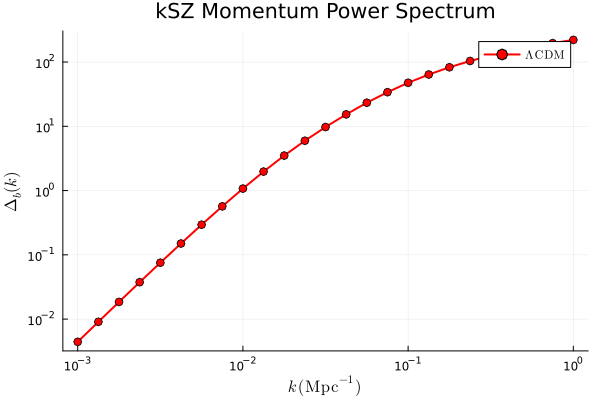

In [12]:

# Create a log-log plot
plot(k_test_values, [results[k] for k in k_values], xscale=:log10, yscale=:log10, 
    xticks = [1e-3, 1e-2, 1e-1, 1e0, 1e1],
    yticks=[1e-10, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
    marker=:o, xlabel=L"k \, (\mathrm{Mpc}^{-1})",
    ylabel=L"\Delta_b(k)", title="kSZ Momentum Power Spectrum", lw=2, label=L"\Lambda\, \mathrm{CDM}", legend=:topright, color=:red)
